# Tuning GCM Parameterizations

The objective of this notebook is to show how GCM closures can be tuned in practice. 
We will assume a specific formulation of a closure and estimate its parameters through a standard optimisation procedure using a procedure similar to Data Assimilation (DA). 

**Resources** : We have used material from Emmanuel Cosme's nice GitHub [repository](https://github.com/ecosme38/Data-Assimilation-Notebooks). 

## The GCM Parameterization Problem 

Here we quickly reintroduce the problem we are trying to solve, our starting point here is {doc}`gcm-parameterization-problem`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt

# L96 provides the "real world", L96_eq1_xdot is the beginning of rhs of X tendency
from L96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot

In [31]:
# Setting the seed gives us reproducible results
np.random.seed(13)

# Create a "real world" with K=8 and J=32
W = L96(8, 32, F=18)

Run "real world" for 3 days to forget initial conditons.

In [32]:
# (store=True save the final state as an initial condition for the next run)
W.run(0.05, 3.0, store=True);

From here on we can use `W.X` as perfect initial conditions for a model and sample the real world using `W.run(dt,T)`

The class defined below is just a sophisticated version of the single time-scale L96 gcm analogue that was defined in 'The Lorenz-96 GCM Analog' notebook.

In [35]:
class GCM:
    def __init__(self, F, parameterization, time_stepping=EulerFwd):
        """
        GCM with paramerization
        Args:
            F: forcing
            parameterization: function that takes parameters and returns a tendency
            time_stepping: time stepping method
        """
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        """
        Args:
            X: state vector
            param: parameters of our closure
        """
        return L96_eq1_xdot(X, self.F) - self.parameterization(param, X)

    def __call__(self, X0, dt, nt, param=[0]):
        """
        Args:
            X0: initial conditions
            dt: time increment
            nt: number of forward steps to take
            param: parameters of our closure
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

We illustrate the concepts here with the help of the simple linear regression parameterization, which was also introduced in the 'The Lorenz-96 GCM Analog'. Remember that this was not a very good parameterization, but it is used to show how imperfect parameterizations can be tuned in different ways. Here we use parameters that were estimated by fitting the linear regression to the true sub-grid tendencies. Such parameter estimates are sometimes also referred to as "offline fitting" estimates.

In [36]:
naive_parameterization = lambda param, X: np.polyval(param, X)

In [44]:
F, dt, T = 18, 0.005, 5.0
gcm = GCM(F, naive_parameterization)
# We pass the parameters that were obtained by fitting the linear in 'The Lorenz-96 GCM Analog' notebook.
X, t = gcm(W.X, dt, int(T / dt), param=[0.85439536, 0.75218026])
# We also simulate a case with no parameterization, to show that even the imperfect parameterization is helpful.
X_no_param, t = gcm(W.X, dt, int(T / dt), param=[0., 0.])

Now we compare the model with the parameterization and trajectories from the "real world" truth.

In [45]:
# This samples the real world with the same time interval as "dt" used by the model
X_true, _, _ = W.run(dt, T)

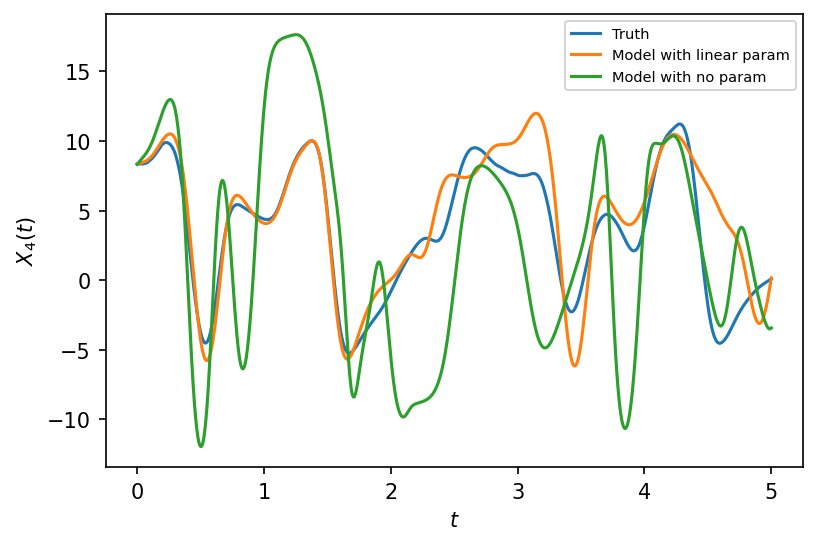

In [47]:
plt.figure(dpi=150)
plt.plot(t, X_true[:, 4], label="Truth")
plt.plot(t, X[:, 4], label="Model with linear param")
plt.plot(t, X_no_param[:, 4], label="Model with no param")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend(fontsize=7);

The figure above show that the model with linear parameterization outperforms the model with no parameterization. Next we discuss if these parameter estimates can be made even better. 

## Variational estimation of optimal parameters for a predefined closure

We will try here to estimate the parameters of `naive_parameterization` with a variational approach. This is different from the way the parameters used above were estimated, which had used an offline fitting approach. 

In [56]:
# - assuming the formulation of the parameterization
gcm = GCM(F, naive_parameterization)

### Estimating parameters based on one initial condition and one time step

#### Cost function 

What we will be doing here is very close to what is done with classical variational data assimilation, where we try to estimate the state of the parameters of a model through the minimization of a cost function $J$. This is also very close to what is done when parameterizations are encoded as neural networks. 

We introduce a cost function $J(p)$ which depends on the parameters of the closure. 

$$J(p) = ||X_p - X_{true}||_{d}$$

where $p=[p1,p2]$, $X_p$ is GCM solution computed with with parameters $p$ and $||\cdot ||_{d}$ is one of the distances above. 


In [57]:
def norm_initial_tendency(X1, X2):
    T1 = X1[1, :] - X1[0, :]
    T2 = X2[1, :] - X2[0, :]
    return np.sqrt((T1 - T2) ** 2).mean(axis=0)

In [58]:
def cost_function(param):
    F, dt, T = 18, 0.01, 0.01
    X_gcm, t = gcm(W.X, dt, int(T / dt), param=param)
    return norm_initial_tendency(X_true, X_gcm)

#### Minimization 

Since the problem dimension is only two ( $p=[p1,p2]$ ), we can use efficient derivative-free optimization methods.

In [59]:
prior = np.array([0.85439536, 0.75218026])  #  prior
res = opt.minimize(cost_function, prior, method="Powell")
opt_param = res["x"]

In [60]:
print(f"Optimized parameters = {opt_param}")

Optimized parameters = [ 1.19216321 -0.19535697]


##### Let's test the closure.

In [61]:
F, dt, T = 18, 0.01, 100.0
gcm = GCM(F, naive_parameterization)
X_optimized, t = gcm(W.X, dt, int(T / dt), param=opt_param)
X_prior, t = gcm(W.X, dt, int(T / dt), param=prior)

# - ... the true state
X_true, _, _ = W.run(dt, T)

##### Results

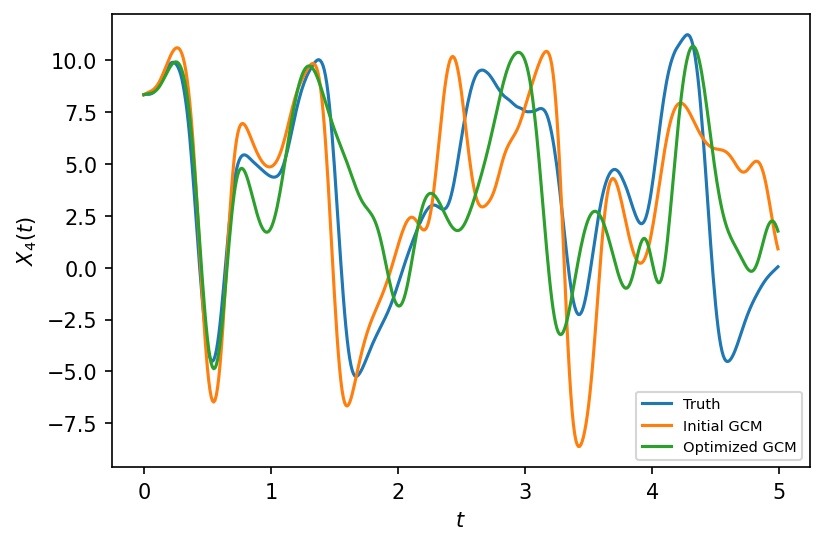

In [62]:
plt.figure(dpi=150)
plt.plot(t[:500], X_true[:500, 4], label="Truth")
plt.plot(t[:500], X_prior[:500, 4], label="Initial GCM")
plt.plot(t[:500], X_optimized[:500, 4], label="Optimized GCM")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend(fontsize=7);

The results are better but not great. This problem is related to the question of *a priori* versus *a posteriori* skill in Large Eddy Simulation (LES) closures. 


### Estimating parameters which optimize longer trajectories

In [63]:
F, dt, T = 18, 0.01, 5.0
gcm = GCM(F, naive_parameterization)
X_true, _, _ = W.run(dt, T)

In [64]:
X_gcm, t = gcm(W.X, dt, int(T / dt), param=[0, 0])

/home/jovyan/L96_demo/L96env/lib/python3.9/site-packages/numpy/lib/polynomial.py:771: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [65]:
# - pointwise distance :
def pointwise(X1, X2, L=1.0):
    # computed over some window t<L.
    D = (X1 - X2)[np.where(t < L)]
    return np.sqrt(D**2).mean(axis=0)

In [66]:
def cost_function(param):
    F, dt, T = 18, 0.01, 5
    X_gcm, t = gcm(W.X, dt, int(T / dt), param=param)
    return pointwise(X_true, X_gcm, L=5.0).sum()

In [67]:
prior = np.array([0.85439536, 0.75218026])  #  prior
res = opt.minimize(cost_function, prior, method="Powell")
opt_param = res["x"]

/tmp/ipykernel_3009/3672341191.py:5: RuntimeWarning: overflow encountered in square
  return np.sqrt(D**2).mean(axis=0)


In [70]:
print(f"Optimized parameters = {opt_param}")

Optimized parameters = [0.88644175 0.74928667]


##### Let's test the closure.

In [68]:
F, dt, T = 18, 0.01, 100.0
gcm = GCM(F, naive_parameterization)
X_optimized, t = gcm(W.X, dt, int(T / dt), param=opt_param)
X_prior, t = gcm(W.X, dt, int(T / dt), param=prior)
X_true, _, _ = W.run(dt, T)

##### Results

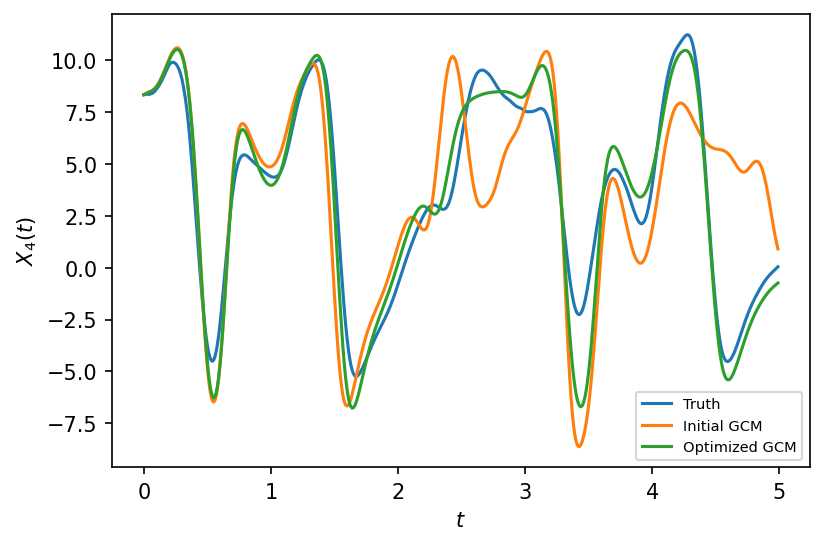

In [69]:
plt.figure(dpi=150)
plt.plot(t[:500], X_true[:500, 4], label="Truth")
plt.plot(t[:500], X_prior[:500, 4], label="Initial GCM")
plt.plot(t[:500], X_optimized[:500, 4], label="Optimized GCM")
plt.xlabel("$t$")
plt.ylabel("$X_4(t)$")
plt.legend(fontsize=7);

The closure produces better results but it is not clear how this would generalize to unseen initial conditions. 

## Discussion and possible next steps:

 - Estimating parameters over one time-step but with an ensemble of initial conditions. 
 - Use neural networks to encode closures.
 - Explore the feasability of differentiable GCMs. 